# Binary classification of images with a convolutional DNN

In [ ]:
!apt-get install unzip

!pip install -U --no-cache-dir \
  tensorflow==1.12.0 \
  tensorflow-gpu==1.12.0 \
  kaggle \
  pillow==3.4.1 \
  scipy

In [ ]:
!echo '{"username":"","key":""}' > /content/.kaggle/kaggle.json \
  && chmod 600 /content/.kaggle/kaggle.json
        
!KAGGLE_CONFIG_DIR=/content/.kaggle kaggle competitions download -c dogs-vs-cats -p /content/data

!unzip -n -q /content/data/train.zip -d /content/data
!unzip -n -q /content/data/test1.zip -d /content/data

The data I have for this problem is a large collection of images containing either a cat or a dog. The sizes of these images vary.

Populating the interactive namespace from numpy and matplotlib
Image count: 25000


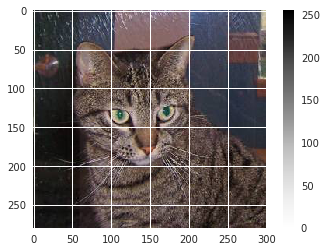

In [19]:
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")
%pylab inline

original_data_dir = '/content/data/train'

original_data_count = len([name for name in os.listdir(original_data_dir)])
print("Image count: %s" % original_data_count)

filename = os.path.join(original_data_dir, 'cat.1.jpg')
img = image.load_img(filename)

plt.imshow(img)
plt.colorbar()
plt.show()

I want to make this a small data problem so I'll seperate the training data into three collections. A training set of 1000. A validation set of 500. And, a test set of 500. Sub directories are added for the two class as I'll be using Keras's ImageDataGenerator to read in the images.

In [6]:
import shutil

base_dir = '/content/data/cats-dogs-small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

try:
    os.mkdir(base_dir)

    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)

    os.mkdir(train_cats_dir)
    for i in range(1000):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(train_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)        
    
    os.mkdir(train_dogs_dir)
    for i in range(1000):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(train_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    os.mkdir(validation_cats_dir)
    for i in range(1000, 1500):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(validation_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(validation_dogs_dir)
    for i in range(1000, 1500):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(validation_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(test_cats_dir)
    for i in range(1500, 2000):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(test_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(test_dogs_dir)
    for i in range(1500, 2000):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(test_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)
except:
    pass

# check image collections are sized correctly
print('Train cats: %s' % len(os.listdir(train_cats_dir)))
print('Train dogs: %s' % len(os.listdir(train_dogs_dir)))
print('Validate cats: %s' % len(os.listdir(validation_cats_dir)))
print('Validate dogs: %s' % len(os.listdir(validation_dogs_dir)))
print('Test cats: %s' % len(os.listdir(test_cats_dir)))
print('Test dogs: %s' % len(os.listdir(test_dogs_dir)))

Train cats: 1000
Train dogs: 1000
Validate cats: 500
Validate dogs: 500
Test cats: 500
Test dogs: 500


Images in JPEG format really aren't suitable inputs for the model. They need reworked into tensors. Decoding a JPEG into a bitmap gives me a tensor with shape (150, 150, 3).

In [7]:
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


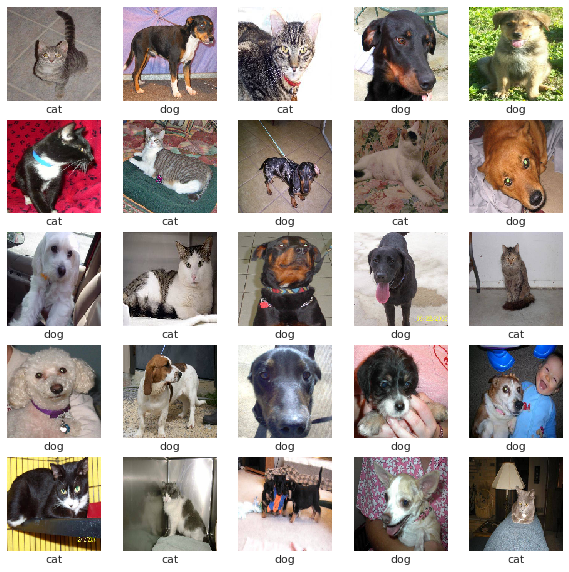

In [20]:
for x_batch, y_batch in train_generator:
    images = x_batch
    labels = list(map(lambda x: 'dog' if x == 1.0 else 'cat', y_batch))
    break

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=1e-4),
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

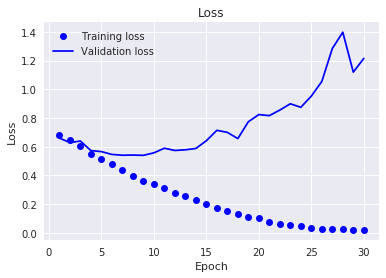

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = range(1, len(loss) + 1)

plt.plot(num_epochs, loss, 'bo', label='Training loss')
plt.plot(num_epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

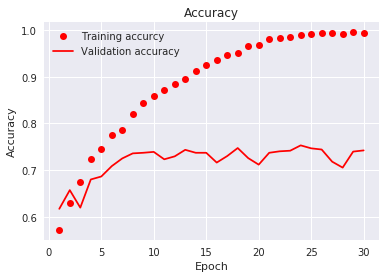

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(num_epochs, acc, 'ro', label='Training accurcy')
plt.plot(num_epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

My model has the characteristics of overfitting. Accuracy on the training data increases Linearly towards 100% while accuracy on the validation data stalls before the 10th epoch.